In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mle-ese-mock/train (5).csv
/kaggle/input/mle-ese-mock/submission (6).csv
/kaggle/input/mle-ese-mock/test (4).csv


In [28]:
# ============================================================
# CONFIG SECTION (EDIT FOR NEW PROBLEMS ONLY)
# ============================================================

TRAIN_PATH = "/kaggle/input/mle-ese-mock/train (5).csv"
TEST_PATH  = "/kaggle/input/mle-ese-mock/test (4).csv"

ID_COL     = "id"
TARGET_COL = "quality_grade"

SUBMISSION_PREFIX = "Status"
RANDOM_STATE = 42
USE_CATBOOST = False  # Set False to use HistGradientBoostingClassifier

In [29]:
# ============================================================
# STEP 1: IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Optional: CatBoost (strong performance with categorical features)
if USE_CATBOOST:
    from catboost import CatBoostClassifier

In [30]:
# ============================================================
# STEP 2: LOAD DATA
# ============================================================

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

test_id = test[ID_COL]
test = test.drop(columns=[ID_COL])

display(train)
print(train.shape)

,id,fruit_type,weight_g,diameter_cm,color_grade,firmness_score,brix_level,acidity_ph,ripeness_index,bruise_area_pct,moisture_pct,shelf_life_days,harvest_age_days,storage_type,origin_region,quality_grade
0,0,mango,169.20,6.65,dull,9.37,15.88,3.77,0.93,0.00,79.43,9,13,ambient,local,Q2_fresh
1,1,banana,191.83,7.77,normal,6.63,12.32,3.84,0.71,1.94,77.63,8,19,cold,local,Q6_juice_low
2,2,mango,180.29,6.34,normal,6.70,8.31,3.66,0.63,10.52,80.19,7,16,ambient,import,NaN
3,3,banana,187.18,7.19,vibrant,6.99,13.36,3.76,0.65,5.62,73.60,9,11,ambient,local,Q5_juice_high
4,4,orange,185.25,8.12,normal,6.78,11.13,4.06,0.64,11.53,77.13,6,16,ambient,import,Q6_juice_low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,2245,orange,186.40,7.76,dull,7.87,13.70,4.15,0.38,11.79,75.80,6,13,cold,import,Q8_local_sale
2246,2246,mango,194.88,8.37,dull,6.55,15.63,3.84,0.58,13.16,75.62,5,11,ambient,local,Q6_juice_low
2247,2247,banana,190.06,8.39,dull,6.70,10.73,3.82,0.54,0.85,73.46,12,16,ambient,import,Q6_juice_low
2248,2248,mango,162.64,7.66,dull,7.09,12.95,3.89,0.53,8.26,77.80,7,11,cold,local,Q6_juice_low


(2250, 16)


In [31]:
# ============================================================
# STEP 3: CLEAN TARGET
# ============================================================

train = train.dropna(subset=[TARGET_COL])
X = train.drop(columns=[ID_COL, TARGET_COL])
y = train[TARGET_COL]

In [32]:
# ============================================================
# STEP 4: FEATURE TYPE DETECTION (AUTO)
# ============================================================

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [33]:
# ============================================================
# STEP 5: SAFE OUTLIER HANDLING (IQR CAPPING)
# ============================================================

def cap_outliers_iqr(df, numeric_cols):
    df = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

X = cap_outliers_iqr(X, numeric_features)
test[numeric_features] = cap_outliers_iqr(test, numeric_features)[numeric_features]

In [34]:
# ============================================================
# STEP 6: PREPROCESSING PIPELINES
# ============================================================

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [35]:
# ============================================================
# STEP 7: MODEL SETUP
# ============================================================

if USE_CATBOOST:
    # CatBoost handles categorical features natively
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='MultiClass',
        random_seed=RANDOM_STATE,
        verbose=100,
        early_stopping_rounds=50
    )
else:
    model = HistGradientBoostingClassifier(
        loss="log_loss",
        max_iter=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=RANDOM_STATE
    )

In [36]:
# ============================================================
# STEP 8: FULL PIPELINE
# ============================================================

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

In [37]:
# ============================================================
# STEP 9: LABEL ENCODING
# ============================================================

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [38]:
# ============================================================
# STEP 10: TRAIN-VALIDATION SPLIT
# ============================================================

X_train, X_val, y_train_enc, y_val_enc = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)

In [40]:
# ============================================================
# STEP 11: TRAIN MODEL
# ============================================================

if USE_CATBOOST:
    # CatBoost can take categorical features indices
    cat_cols_idx = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]
    model.fit(
        X_train, y_train_enc,
        eval_set=(X_val, y_val_enc),
        cat_features=cat_cols_idx,
        verbose=100
    )
else:
    pipeline.fit(X_train, y_train_enc)

In [41]:
# ============================================================
# STEP 12: VALIDATION METRIC
# ============================================================

if USE_CATBOOST:
    val_proba = model.predict_proba(X_val)
else:
    val_proba = pipeline.predict_proba(X_val)

loss = log_loss(y_val_enc, val_proba)
acc = accuracy_score(y_val_enc, val_proba.argmax(axis=1))

print(f"Validation Log Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

Validation Log Loss: 1.7994
Validation Accuracy: 0.4241


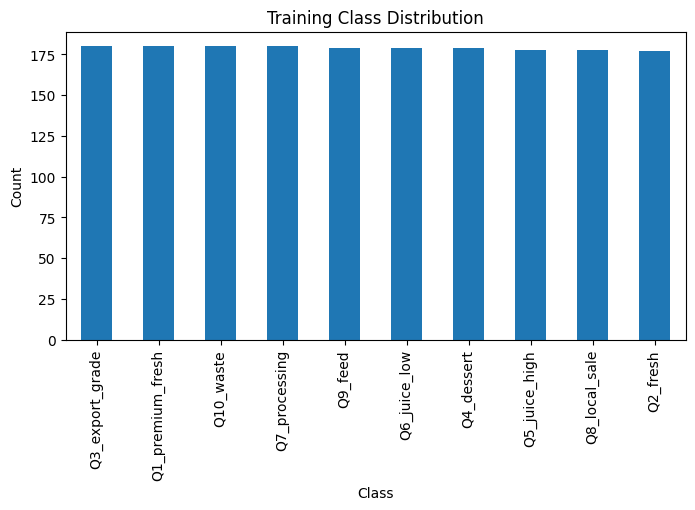

In [42]:
# ============================================================
# STEP 13: CLASS DISTRIBUTION VISUALIZATION
# ============================================================

plt.figure(figsize=(8,4))
pd.Series(y_train_enc).map(lambda x: le.inverse_transform([x])[0]).value_counts().plot(kind='bar')
plt.title("Training Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [43]:
# ============================================================
# STEP 14: TEST PREDICTIONS
# ============================================================

if USE_CATBOOST:
    test_proba = model.predict_proba(test)
else:
    test_proba = pipeline.predict_proba(test)

In [44]:
# ============================================================
# STEP 15: SUBMISSION FILE
# ============================================================

class_names = le.classes_
submission = pd.DataFrame(
    test_proba,
    columns=[f"{SUBMISSION_PREFIX}_{cls}" for cls in class_names]
)

submission.insert(0, ID_COL, test_id)
display(submission)

,id,Status_Q10_waste,Status_Q1_premium_fresh,Status_Q2_fresh,Status_Q3_export_grade,Status_Q4_dessert,Status_Q5_juice_high,Status_Q6_juice_low,Status_Q7_processing,Status_Q8_local_sale,Status_Q9_feed
0,0,8.089191e-08,1.003819e-04,2.642957e-01,7.152855e-02,6.631948e-01,7.965795e-04,8.174480e-05,1.038255e-06,1.084519e-06,2.153500e-08
1,1,9.648008e-01,6.850599e-09,5.380287e-09,4.348676e-08,2.655091e-08,1.166238e-08,2.388832e-07,1.050694e-05,1.747248e-04,3.501364e-02
2,2,1.358072e-07,7.857619e-01,1.210989e-01,9.312823e-02,3.751406e-06,4.056762e-06,2.084416e-06,6.870713e-07,1.523560e-07,6.321342e-08
3,3,6.798275e-07,8.737811e-04,1.124816e-02,9.624958e-01,3.308109e-03,2.195221e-02,1.071237e-04,7.002633e-06,6.971084e-06,1.936811e-07
4,4,2.283483e-03,8.826111e-08,1.571530e-07,3.974260e-06,9.108591e-06,3.515227e-05,2.481839e-01,5.148657e-01,2.245054e-01,1.011304e-02
...,...,...,...,...,...,...,...,...,...,...,...
745,745,5.545539e-04,4.507659e-07,8.134650e-07,6.375305e-07,8.686338e-06,8.837042e-05,3.195278e-04,5.989005e-02,9.050449e-01,3.409202e-02
746,746,9.673868e-01,1.221426e-07,2.015196e-07,1.399789e-07,1.050055e-06,7.934292e-07,5.633501e-06,4.179019e-05,2.829840e-03,2.973368e-02
747,747,2.659979e-01,1.399194e-07,4.950408e-07,1.014387e-06,7.483061e-07,1.987097e-07,4.538544e-05,2.532077e-03,5.923194e-01,1.391026e-01
748,748,7.765870e-02,1.058546e-07,1.726489e-07,5.385408e-07,5.142008e-06,1.670328e-06,1.958917e-03,1.662126e-02,4.182969e-03,8.995705e-01


In [27]:
submission.to_csv("submission.csv", index=False)

print("\n✅ Submission created!")


✅ Submission created!
